In [35]:
# Import Libraries
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from datetime import datetime, timedelta

## Reflect Tables into SQLAlchemy ORM

In [18]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [20]:
# Create engine using the 'hawaii.sqlite' database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [22]:
# Declare a Base using automap_base()
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [24]:
# Print all of the classes mapped to the Base
Base.classes.keys()


['measurement', 'station']

In [31]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [26]:
# Create a session
session = Session(engine)


## Exploratory Precipitation Analysis

In [33]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).scalar()
print(recent_date)


2017-08-23


<Axes: title={'center': 'Precipatation Over a Year'}, xlabel='Date', ylabel='Precipitation(in)'>

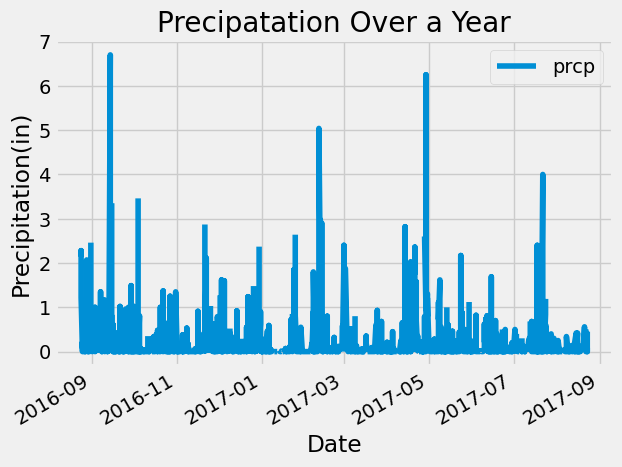

In [52]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
recent_date = session.query(func.max(Measurement.date)).scalar()
# Calculate the date one year from the last date in data set.
if isinstance(recent_date, str):
    recent_date = datetime.strptime(recent_date, '%Y-%m-%d')

one_year = recent_date - timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
prec_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year).\
    filter(Measurement.date <= recent_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prec_df = pd.DataFrame(prec_data, columns=['date', 'prcp'])

# Sort the dataframe by date
prec_df['date'] = pd.to_datetime(prec_df['date'])
prec_df.sort_values('date', inplace=True)


# Use Pandas Plotting with Matplotlib to plot the data
prec_df.plot(x='date', y='prcp', title='Precipatation Over a Year', xlabel='Date', ylabel='Precipitation(in)')


In [54]:
# Use Pandas to calculate the summary statistics for the precipitation data
stats = prec_df['prcp'].describe()
print(stats)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64


## Exploratory Station Analysis

In [57]:
# Design a query to calculate the total number of stations in the dataset
stations_count = session.query(Station.station).count()
stations_count

9

In [80]:
# Design a query to find the most active staions (the ones with the most rows)
# List the stations and their counts in descending order.
from sqlalchemy.orm import aliased

MeasurementAlias = aliased(Measurement)

most_active_stations = session.query(
    Station.station,
    func.count(MeasurementAlias.id).label('observation_count')
).select_from(Station).join(MeasurementAlias, Station.station == MeasurementAlias.station).group_by(Station.station).order_by(func.count(MeasurementAlias.id).desc()).all()

for station, count in most_active_stations:
    print(f"Station ID: {station}, Count: {count}")

    



Station ID: USC00519281, Count: 2772
Station ID: USC00519397, Count: 2724
Station ID: USC00513117, Count: 2709
Station ID: USC00519523, Count: 2669
Station ID: USC00516128, Count: 2612
Station ID: USC00514830, Count: 2202
Station ID: USC00511918, Count: 1979
Station ID: USC00517948, Count: 1372
Station ID: USC00518838, Count: 511


In [84]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average tempertature
most_active_station = 'USC00519281'
results = session.query(func.min(Measurement.tobs),
                        func.max(Measurement.tobs),
                        func.avg(Measurement.tobs)
                       ).filter(Measurement.station == most_active_station).all()
lowest_temp, highest_temp, average_temp = results[0]

print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {average_temp}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


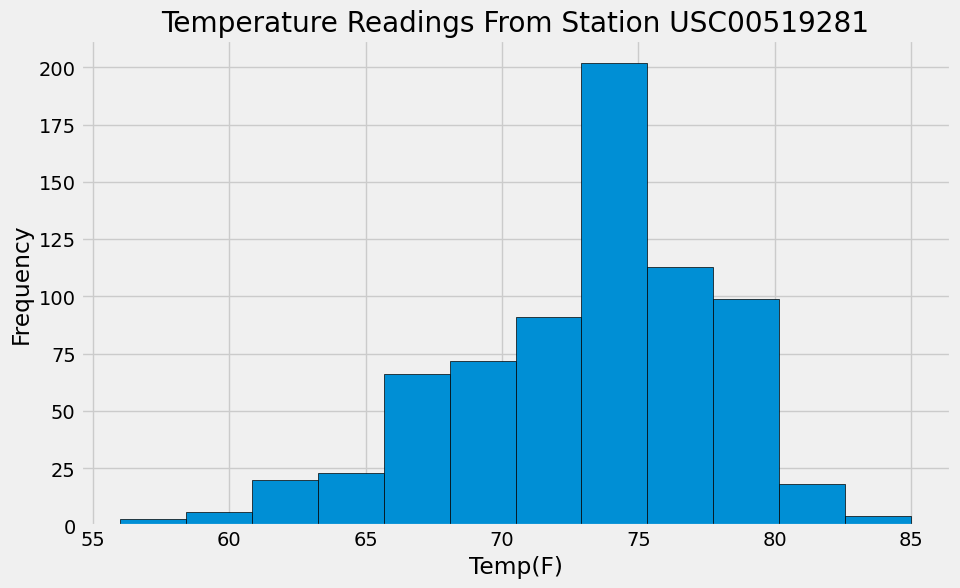

In [86]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = """
SELECT date, tobs
FROM measurement
WHERE station = 'USC00519281'
AND date >= DATE('2016-08-23', '-12 months')
"""
station_df = pd.read_sql(query, engine)

plt.figure(figsize=(10, 6))
plt.hist(station_df['tobs'], bins=12, edgecolor='black')
plt.title('Temperature Readings From Station USC00519281')
plt.xlabel('Temp(F)')
plt.ylabel('Frequency')
plt.show()

## Close Session

In [89]:
# Close Session
session.close()